In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import torch
import seaborn as sns
from torch import optim
import torch.nn.functional as F

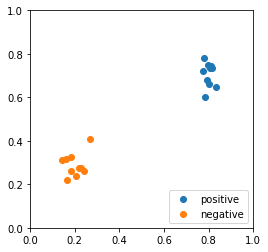

In [2]:
data_x_pos = np.random.multivariate_normal([0.8, 0.7], [[0.001, 0], [0, 0.003]], 10)
data_x_neg = np.random.multivariate_normal([0.2, 0.3], [[0.001, 0], [0, 0.003]], 10)
data_y_pos = np.ones(10)
data_y_neg = np.zeros(10)
data_x = np.vstack([data_x_pos, data_x_neg])
data_y = np.hstack([data_y_pos, data_y_neg])
fig, ax = plt.subplots(figsize=(4, 4))
plt.scatter(data_x_pos[:,0], data_x_pos[:,1], label='positive')
plt.scatter(data_x_neg[:,0], data_x_neg[:,1], label='negative')
ax.legend(loc='lower right')
ax.set_xlim((0,1))
ax.set_ylim((0,1))

data_x = torch.from_numpy(data_x).float()
data_y = torch.from_numpy(data_y).float()

In [4]:
# data_x = np.random.multivariate_normal([0.8, 0.7], [[0.001, 0], [0, 0.003]], 10)
# data_y = np.ones(10)
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.scatter(data_x[:,0], data_x[:,1])
# ax.set_xlim((0,1))
# ax.set_ylim((0,1))
# data_x = torch.from_numpy(data_x).float()
# data_y = torch.from_numpy(data_y).float()

Parameter containing:
tensor([[ 0.7351,  1.0462, -0.6927, -0.5830]], requires_grad=True) Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor([[2.3752, 2.5604, 0.2497, 0.7390]], requires_grad=True) Parameter containing:
tensor([-3.1051], requires_grad=True)


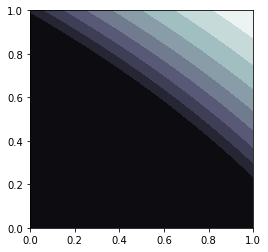

In [143]:
class QuadraticKernel(nn.Module):

  def forward(self, input):
    return torch.cat([input, input*input], dim=1)

class ReLog(nn.Module):

  def forward(self, input):
    return torch.log(F.relu(input) + 1)

def plot_model(model):
  val_x = np.linspace(0, 1, 100)
  val_y = np.linspace(0, 1, 100)
  val_x, val_y = np.meshgrid(val_x, val_y)
  input = np.stack([val_x.flatten(), val_y.flatten()], axis=-1)
  val_z = model(torch.from_numpy(input).float()).detach().numpy().reshape(val_x.shape)
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.contourf(val_x, val_y, val_z, 10, cmap=plt.cm.bone, origin='lower')

def demo_model(regularization=lambda m: 0, use_quadratic_kernel=False, n_epochs=100, lr=0.1):
  if use_quadratic_kernel:
    model = nn.Sequential(
        QuadraticKernel(),
        nn.Linear(4, 1),
        nn.ReLU(),
        ReLog()
    )
    linear_module = model[1]
    with torch.no_grad():
        linear_module.weight[:,:2].fill_(1).add_(torch.randn(2)*0.5)
        linear_module.weight[:,2:].fill_(-1).add_(torch.randn(2)*0.5)
        linear_module.bias.fill_(0).add(torch.randn(1)*0.1)
        print(linear_module.weight, linear_module.bias)
  else:
    model = nn.Sequential(
        nn.Linear(2, 1),
        nn.ReLU(),
        ReLog()
    )
    linear_module = model[0]
    with torch.no_grad():
      linear_module.weight.abs_() # make sure that the model learn
  # train
  lr = 0.5
  loss_func = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  for epoch in range(n_epochs):
      optimizer.zero_grad()
      pred = model(data_x)
      loss = loss_func(pred.flatten(), data_y) + regularization(linear_module)
      loss.backward()
      optimizer.step()
      # print(loss.item())
  # acc = ((pred-0.5)*(data_y-0.5) >= 0).float().mean().item()
  # print('Accuracy:', acc)
  # print(pred, data_y)
  plot_model(model)
  print(linear_module.weight, linear_module.bias)
  return model

model = demo_model(lambda m: 0, use_quadratic_kernel=True)

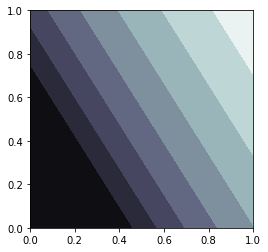

In [7]:
max_margin = lambda m: 0.01*(m.weight*m.weight).mean()
model_reg = demo_model(max_margin)

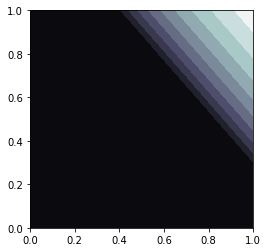

In [8]:
class MaxFitL2(object):
  def __init__(self, alpha=0.02, beta=0.1, exempt_quadratic_weights=False):
    self.alpha = alpha
    self.beta = beta
    self.exempt_quadratic_weights = exempt_quadratic_weights
  def __call__(self, m):
    if self.exempt_quadratic_weights:
        w = m.weight[:,:m.weight.shape[1]//2]
    else:
        w = m.weight
    return self.alpha*(w*w).mean() + self.beta*m.bias.mean()

model_reg = demo_model(MaxFitL2(alpha=0.03, beta=0.2))

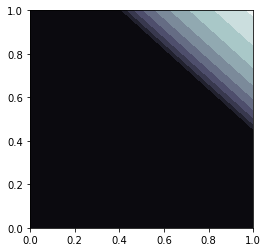

In [21]:
class MaxFitL1(object):
  def __init__(self, alpha=0.01, beta=0.1, exempt_quadratic_weights=False):
    self.alpha = alpha
    self.beta = beta
    self.exempt_quadratic_weights = exempt_quadratic_weights
  def __call__(self, m):
    if self.exempt_quadratic_weights:
        w = m.weight[:,:m.weight.shape[1]//2]
    else:
        w = m.weight
    return self.alpha*w.abs().mean() + self.beta*m.bias.mean()

model_reg = demo_model(MaxFitL1())

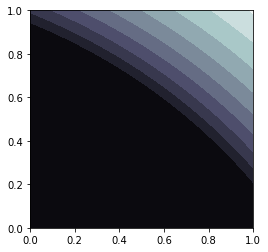

In [22]:
model = demo_model(use_quadratic_kernel=True)

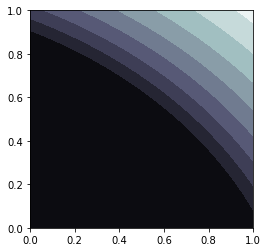

In [23]:
model = demo_model(max_margin, use_quadratic_kernel=True)

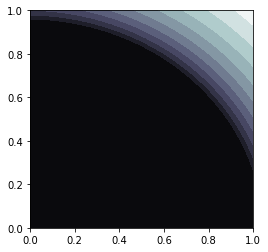

In [24]:
model = demo_model(MaxFitL2(0.1, 0.05, True), use_quadratic_kernel=True)

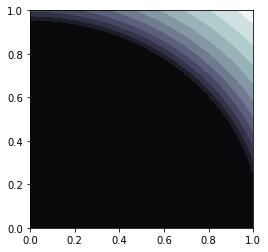

In [26]:
model = demo_model(MaxFitL1(0.1, 0.05, True), use_quadratic_kernel=True)

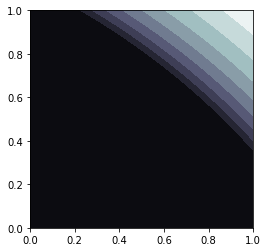

In [35]:
model = demo_model(MaxFitL1(0.01, 0.03), use_quadratic_kernel=True)

# More negative samples

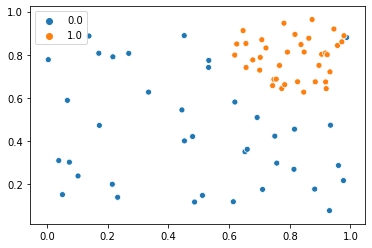

In [14]:
n = 200
data_x = np.random.rand(n, 2)
data_y = np.zeros(n)
x1, x2 = data_x[:,0], data_x[:,1]
f = np.sqrt((x1-0.8)**2 + (x2-0.8)**2) - 0.2
neg_indices, = (f > 0).nonzero()
pos_indices, = (f < 0).nonzero()
neg_indices = neg_indices[:len(pos_indices)]
data_y[f < 0] = 1
data_x = np.vstack([data_x[neg_indices], data_x[pos_indices]])
data_y = np.hstack([data_y[neg_indices], data_y[pos_indices]])
sns.scatterplot(data_x[:,0], data_x[:,1], hue=data_y)
data_x = torch.from_numpy(data_x).float()
data_y = torch.from_numpy(data_y).float()

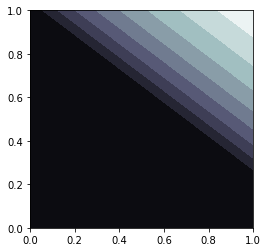

In [15]:
model = demo_model()

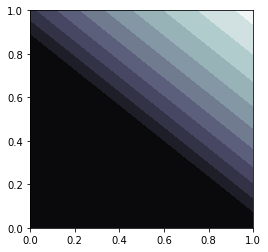

In [16]:
model_reg = demo_model(max_margin)

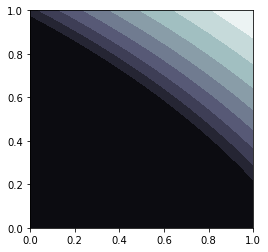

In [17]:
model = demo_model(use_quadratic_kernel=True, n_epochs=150)

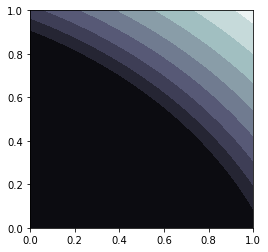

In [18]:
model = demo_model(use_quadratic_kernel=True, n_epochs=150, regularization=max_margin)

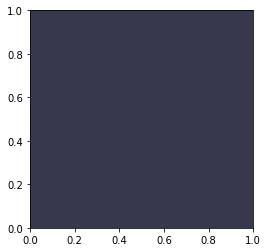

In [19]:
model = demo_model(use_quadratic_kernel=True, n_epochs=150, regularization=MaxFitL2())

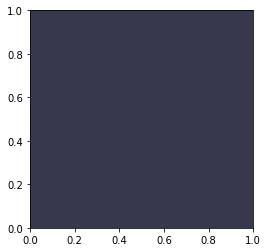

In [20]:
model = demo_model(use_quadratic_kernel=True, n_epochs=150, regularization=MaxFitL1())

# Plot some quadratic curves

(0.0, 0.7)

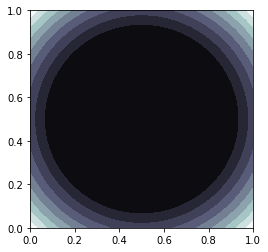

In [59]:
def plot_curve(a, b, c, d, e):
  val_x = np.linspace(0, 1, 100)
  val_y = np.linspace(0, 1, 100)
  val_x, val_y = np.meshgrid(val_x, val_y)
  val_z = np.clip(a*val_x*val_x + b*val_y*val_y + c*val_x + d*val_y + e, a_min=0, a_max=1000)
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.contourf(val_x, val_y, val_z, 10, cmap=plt.cm.bone, origin='lower',
              vmin=0, vmax=np.max(val_z))
  return np.min(val_z), np.max(val_z)

plot_curve(2,2,-2,-2,0.7)

(0.0, 0.4999489847974697)

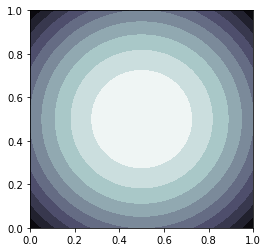

In [62]:
plot_curve(-1,-1,1,1,0)

(0.0, 1.5126401833889969)

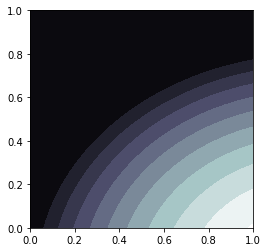

In [95]:
r = lambda: np.random.randn()
plot_curve(-1+r(),-1+r(),1+r(),1+r(),r()*0.1)

(0.0, 0.45902758187303233)

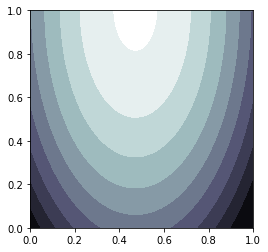

In [96]:
plot_curve(-1+r(),-1+r(),1+r(),1+r(),r()*0.1)

(0.1120310334569792, 2.9593359569758286)

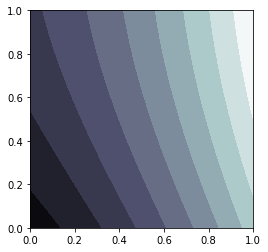

In [97]:
plot_curve(-1+r(),-1+r(),1+r(),1+r(),r()*0.1)

(0.0, 1.9754660142282083)

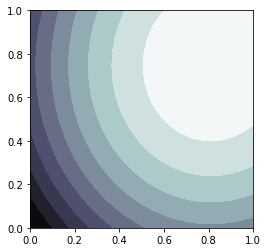

In [98]:
plot_curve(-1+r(),-1+r(),1+r(),1+r(),r()*0.1)

(0.0, 2.8056192817053627)

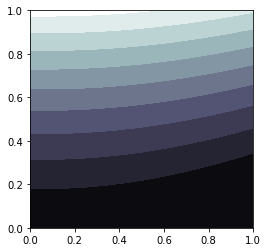

In [99]:
plot_curve(-1+r(),-1+r(),1+r(),1+r(),r()*0.1)

(0.0, 0.9988063731961723)

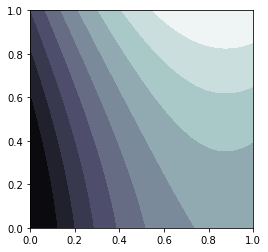

In [100]:
plot_curve(-1+r(),-1+r(),1+r(),1+r(),r()*0.1)

(0.019300066175789415, 0.9925526362032042)

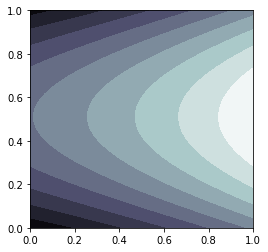

In [101]:
plot_curve(-1+r(),-1+r(),1+r(),1+r(),r()*0.1)

(0.0, 0.83760842059142)

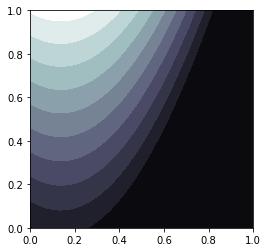

In [102]:
plot_curve(-1+r(),-1+r(),1+r(),1+r(),r()*0.1)